<a href="https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/A3-LargeScaleMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A3 - 古典イジング模型

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/A3-LargeScaleMC.ipynb)

この章ではOpenJijのcore interface (core python interface)の使い方を説明し、簡単な計算のデモンストレーションを行います。

core interfaceは前回までのチュートリアルよりも下部のレイヤーのAPIとなるため、対象読者としては前回までのOpenJijチュートリアルを一通り終えて、イジングモデルやモンテカルロ法などの用語を知っている方を想定しており、

* 最適化問題だけでなくサンプリングや研究用途などより専門的な用途にOpenJijを用いたい
* アニーリングスケジュールの設定や使用するアルゴリズム等を直接触りたい

といった目的に使用できます。

前回ではスピン数$N=5$の小さいシステムでのデモンストレーションを行いましたが、この章ではさらに大規模な計算を通してOpenJij core interfaceの機能、使い方をより詳しく見ていきます。

題材としてランダムイジング模型を取り上げます。この模型は、ハミルトニアンが
\begin{align}
H &= \sum_{i<j}J_{ij}\sigma_i \sigma_j + \sum_{i=1}^{N}h_i \sigma_i \\
\sigma_i &= \pm 1 (i=1 \cdots N)
\end{align}
で与えられて、$J_{ij}, h_{i}$が$(i,j)$に対して様々な値を持つ模型です。  
様々な種類の最適化問題がこのような模型の一番低いエネルギーを求める問題となりますが、エネルギーの最も低い状態を実現する$\sigma_i$を計算するには一般に非常に難しいです。

## 問題の定義 - Graph -

問題を定義してみましょう。`graph`の中の**Dense**モジュールが必要となります。
> `graph`中には基本的に**Dense**モジュールと**Sparse**モジュールがあり、今回の例のように全ての$J_{ij}$で値が定義されている場合には**Dense**モジュールが適しています。多くの$J_{ij}$の要素が0の場合には**Sparse**が適しています。使い方はどちらもほぼ変わりません。

In [8]:
import cxxjij.graph as G
#問題サイズを100とします。
N = 100

graph = G.Dense(N)
#sparseの場合
#graph = G.Sparse(N)

$J_{ij}, h_i$を設定します。今回は平均0、標準偏差1のGauss分布から生成される値を設定します。

In [9]:
!pip install numpy #乱数生成にnumpyを使います。

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        #Jijの値が大きくなりすぎてしまうので、全体の係数を1/Nしています。
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

ここで、縦磁場に関しては、`graph[i]`でも、`graph[i,i]`でもどちらでもアクセスできます。

また、イジングモデルの定義上、$J_{ij}$と$J_{ji}$は自動で同じ値となります。

In [11]:
graph[20] = 0.5
print(graph[20,20])
print(graph[20])
graph[12,34] = -0.6
print(graph[12,34])
print(graph[34,12])

0.5
0.5
-0.6
-0.6


**Dense** (および**Sprase**)は以下のメソッドを持っています。

- .gen_spin(seed)  
    乱数生成のためのseedを与えると、システムサイズ (ここでは$N=100$)分のスピン列を出力します。
    seedがない場合にはランダムにseedが決定されます。
- .size()  
    問題のサイズ($N$)を表示します。
- .adj_nodes(i)  
    インデックス$i$に隣接するノード一覧を表示します。
- .calc_energy(spin)  
    スピン列spinを与えられた際に、エネルギー
    \begin{align}  
    H &= \sum_{i<j}J_{ij}\sigma_i \sigma_j + \sum_{i=1}^{N}h_i \sigma_i
    \end{align}
    を計算します。

## システムの設定 - System -

続いて計算を行うためのシステムを定義します。ここで古典イジング模型か横磁場イジング模型か、また別の模型にするか等を選べます。

まずは古典イジング模型のシステムを作成してみます。`system.make_classical_ising`で作成できます。

In [12]:
import cxxjij.system as S

mysystem = S.make_classical_ising(graph.gen_spin(), graph)

ここで、引数の1つめにはランダムに生成したスピン、2つめはGraphそのものを代入しています。  
これにより初期スピン配位が`graph.gen_spin()`となる古典イジング模型のシステムが作成できます。
> `system.make_classical_ising`は内部でGraphとspinをそのまま保持しています。実装は[ここ](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/system/classical_ising.hpp#L37)にあり、63行目でメンバ変数
```cpp
graph::Spins spin;
const GraphType interaction;
```
が定義されています。  
古典イジング模型に関しては、行列演算ライブラリEigenを用いて最適化されたシステムである`system.make_classical_ising_Eigen`も用意しています。(実装は[ここ](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/system/classical_ising.hpp#L78))   
計算速度はこちらのほうが速いので**実際の用途では`system.make_classical_ising_Eigen`を使うことをおすすめします。**

システムに直接アクセスして、値を読むこともできます。

In [13]:
print(mysystem.spin)

[-1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1]


古典イジング模型以外にも様々なシステムが用意されており、用途別に使うことが出来ます。また、Systemによって初期化の方法は多少異なります。  
後ほど少しずつ紹介していきます。

## アルゴリズムの実行 -Updater, Algorithm-

Systemを定義した後はUpdaterを選択してAlgorithmを実行していきます。  
Systemに大して使用できるUpdaterは決められており、古典イジング模型に対するUpdaterは主に

- [SingleSpinFlip](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/single_spin_flip.hpp#L40) (メトロポリス・ヘイスティング法によるスピン1つずつのアップデート)
- [SwendsenWang](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/swendsen_wang.hpp#L45) (SwendsenWang法によるクラスターアップデート)

が用意されています。  
Algorithmを実行するにはまず**スケジュールリスト**が必要となるため、まずスケジュールリストを作成するところから始めます。

### スケジュールリスト

スケジュールリストは`(パラメータ, モンテカルロステップ数)`のリストで与えられ、パラメータにいれる値はSystemによって異なります。例えば古典イジング模型ならばパラメータとして温度の逆数である逆温度$\beta$を設定します。
例えばスケジュールリストとして

In [14]:
schedule_list = [(0.01, 10),(10, 80),(0.1, 30)]

と設定された場合、逆温度$\beta=0.01$で10モンテカルロステップ、$\beta=10$で80ステップ、$\beta=0.1$で30ステップの計120モンテカルロステップを実行することを意味します。

アニーリングを実行するにあたっては、逆温度は等比級数で増加させていくことが多いため、`utility`にある`make_classical_schedule_list`を使うと便利です。

In [15]:
import cxxjij.utility as U
schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 10)
print(schedule_list)

[((beta: 0.100000) mcs: 20), ((beta: 0.199474) mcs: 20), ((beta: 0.397897) mcs: 20), ((beta: 0.793701) mcs: 20), ((beta: 1.583223) mcs: 20), ((beta: 3.158114) mcs: 20), ((beta: 6.299605) mcs: 20), ((beta: 12.566053) mcs: 20), ((beta: 25.065966) mcs: 20), ((beta: 50.000000) mcs: 20)]


上の例では$\beta=0.1$から$\beta=50$まで、各温度で20モンテカルロステップ計算しながら10段階で温度を変えていくため、計200モンテカルロステップの計算となります。

### Algorithm

続いて、Algorithmを実行していきます。`Algorithm_[Updater]_run`のように書くことで、指定したUpdaterで計算を行うことができます。次例ではSingleSpinFlipを用います。

In [16]:
import cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

一瞬で処理が終わりましたが、この間に計200モンテカルロステップの計算が終わっています。
> `A.Algorithm_SingleSpinFlip_run(mysystem, seed, schedule_list)`とすることで、seedを固定したまま計算を行うことができます。結果に再現性をもたせたい際に使うことができます。

callbackを使用することでAlgorithmの実行中に1モンテカルロステップごとのシステムを取得することができます。古典イジング模型の場合は、システムとパラメータ (逆温度)を引数を持つ関数を作成すれば良いです。

ためしにシステムのエネルギーの値を記録するcallbackを作ってみましょう

In [17]:
energies = []

def callback_log_energy(system, beta):
    #graphは以前にGraphモジュールにて定義したオブジェクトです
    energies.append(graph.calc_energy(system.spin))

このcallbackを用いて同じAlgorithmを実行します。

In [18]:
#スケジュールをもっと長く取ります (計20000モンテカルロステップ)
schedule_list = U.make_classical_schedule_list(0.1, 50, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

記録したシステムのエネルギーを横軸をモンテカルロステップ、縦軸をエネルギーでプロットすると次のようになります。

In [19]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


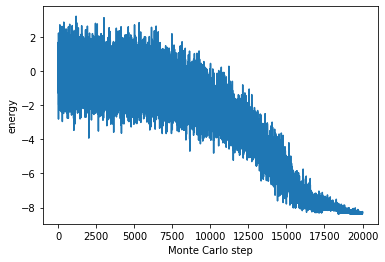

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

このように、アニーリングが進むに連れ徐々にエネルギーが低くなっているのが分かります。Algorithmの動作中にシステムの様子を知りたい時に有用です。

## 結果の取得 -Result-

`result.get_solution`で計算結果であるスピン列を取得できます。古典イジング模型の場合は直接`mysystem.spin`を参照すればスピン列を取得できますが、`result.get_solution`はそれ以外のシステムについてもスピン列を取得できます。

In [21]:
import cxxjij.result as R
print(R.get_solution(mysystem))

[-1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1]


このスピン列がアニーリングによって得られた答えなので、ハミルトニアンの基底状態 (に近い状態)であることが期待されます。

## `system.make_classical_ising_Eigen` 

注釈で述べたように、古典イジング模型には線形代数ライブラリである[Eigen](http://eigen.tuxfamily.org/index.php?title=Main_Page)で実装された`system.make_classical_ising_Eigen`があります。`system.make_classical_ising`との計算速度をシステムサイズを変えて比較してみましょう。

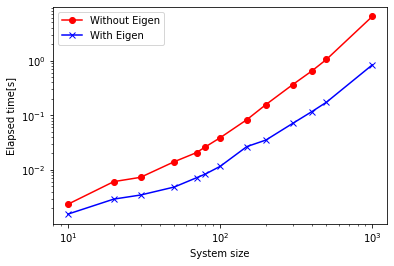

In [25]:
import time

N_list = [10, 20, 30, 50, 70, 80, 100, 150, 200, 300, 400, 500, 1000]

#計算時間
calctime = []
#計算時間 (Eigen実装)
calctime_eigen = []

for N in N_list:
    #Graphの初期化
    graph = G.Dense(N)
    for i in range(N):
        for j in range(N):
            #Jijの値が大きくなりすぎてしまうので、全体の係数を1/Nしています。
            graph[i,j] = 0 if i == j else np.random.normal()/N

    for i in range(N):
        graph[i] = np.random.normal()/N
    
    #Systemの初期化
    mysystem = S.make_classical_ising(graph.gen_spin(), graph)
    mysystem_eigen = S.make_classical_ising_Eigen(graph.gen_spin(), graph)
    
    #スケジュールリスト (2000モンテカルロステップ)
    schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 100)
    
    t1 = time.time()
    #アニーリング (Eigenなし)
    A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)
    t2 = time.time()
    calctime.append(t2-t1)
    
    t1 = time.time()
    #アニーリング (Eigenあり)
    A.Algorithm_SingleSpinFlip_run(mysystem_eigen, schedule_list)
    t2 = time.time()
    calctime_eigen.append(t2-t1)

#結果を両対数プロット
plt.plot(N_list, calctime, 'ro-', label='Without Eigen')
plt.plot(N_list, calctime_eigen, 'bx-', label='With Eigen')
plt.xlabel('System size')
plt.ylabel('Elapsed time[s]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

全体的にEigen実装のほうが計算が早く、大きいシステムサイズではほぼ10倍ほどのスピード差があります。

## C++ core interface

C++ core interfaceでも上記とほぼ同じことが可能ですが、多少の違いがあり、

- seed値を入れる引数には、乱数生成器 (C++11 random)を代入する必要があります。今までのコードはC++で次のようになります。
- Graphクラスで、$J_{ij}, h_i$へのアクセス方法が多少異なります。

今までの内容をC++ core interfaceで記述すると次のようになります。

```cpp
#include <graph/all.hpp>
#include <system/all.hpp>
#include <updater/all.hpp>
#include <algorithm/all.hpp>
#include <result/all.hpp>
#include <utility/schedule_list.hpp>
#include <utility/random.hpp>
#include <random>

#include <iostream>

using namespace openjij;

int main(void){

    //generate dense graph with size N=100
    constexpr std::size_t N = 100;
    auto dense = graph::Dense<double>(N);

    //generate random engine
    auto rand_engine = std::mt19937(0x1234);
    //of course you can specify another random generator that is compatible with C++ random generator, say utility::Xorshift,
    //auto rand_engine = utility::Xorshift(0x1234);
    
    //Gaussian distribution
    auto gauss = std::normal_distribution<>{0, 1};

    //set interactions
    for(std::size_t i=0; i<N; i++){
        for(std::size_t j=0; j<N; j++){
            dense.J(i, j) = (i == j) ? 0 : gauss(rand_engine)/N;
        }
    }

    //set local fields
    for(std::size_t i=0; i<N; i++){
        dense.h(i) = gauss(rand_engine);
    }

    //create classical Ising system
    auto system = system::make_classical_ising(dense.gen_spin(rand_engine), dense);
    //if you use classical Ising system with Eigen implementation, use
    //auto system = system::make_classical_ising<system::USE_EIGEN>(dense.gen_spin(rand_engine), dense);

    //generate schedule list
    //from beta=0.1 to beta=50, 20 Monte Carlo step for each tempearature, 10 samples
    auto schedule_list = utility::make_classical_schedule_list(0.1, 50, 20, 10);

    //or in the case of classical system, you can specify arbitrary schedules by using a std::vector of utility::Schedule<system::classical_system>
    //std::vector<utility::Schedule<system::classical_system>> schedule_list;
    //utility::Schedule<system::classical_system> schedule;
    //schedule.updater_parameter = {0.01};
    //schedule.one_mc_step = 10; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule);
    //
    //schedule.updater_parameter = {10};
    //schedule.one_mc_step = 80; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule);
    //
    //schedule.updater_parameter = {0.1};
    //schedule.one_mc_step = 30; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule); //schedule_list -> [(0.01, 10), (10, 80), (0.1, 30)]


    //do annealing (updater: SingleSpinFlip)
    algorithm::Algorithm<updater::SingleSpinFlip>::run(system, rand_engine, schedule_list);

    //show spins
    std::cout << "The result spins are [";
    for(auto&& elem : result::get_solution(system)){
        std::cout << elem << " ";
    }

    std::cout << "]" << std::endl;
}

```